# Benchmark of manifold CAC algorithm on TSP

In [1]:
using DelimitedFiles
using Statistics

include("lib.jl")
include("manifoldCAC.jl")


basic_rule3! (generic function with 1 method)

In [2]:
using IJulia
using Manopt, Manifolds, Random, LinearAlgebra, ManifoldDiff
using ManifoldDiff: grad_distance, prox_distance
using DifferentialEquations
using Plots, DataFrames

In [3]:
folder = "./TSP_benchmark/"

# Create the folder if it does not exist
if !isdir(folder)
    mkdir(folder)
    println("Folder created: $folder")
end


## Generation of random TSP instances

In [50]:
N_list = [5,8,10]    # size of the TSP
n = 10   # number of instances

10

In [5]:

if false
    
    for N in N_list
        
        for i in 1:n
        
            #generate random TSP distance matrix
            D = generate_tsp_distance_matrix(N, true)
            
            #brute force its ground-state
            H, H0 = brute_force(N,D)
            
            # Write the matrix to the file
            file_path = joinpath(folder, "rTSP_D_$(N)_$(i).dat")
            file_path_H0 = joinpath(folder, "rTSP_H0_$(N)_$(i).dat")
            writedlm(file_path, D, ' ')  # Using space as a delimiter
            writedlm(file_path_H0, H0, ' ')  # Using space as a delimiter
        
            println("Generated TSP $(i) with N=$(N)")
            
        end
    
    end

end

In [6]:
## Run algorithm

In [51]:
# 0) parameters of the solver

steps = 500
beta0 = 0.1
lambda = 0.1
gamma = 10.0

K = 10 #nb of trajectories to evaluate success probability per instance


10

In [52]:

p0_mat = []
t0_mat = []

for N in N_list

    p0_list = []
    t0_list = []

    M₀ = UnitaryMatrices(N, ℝ)
            
    for i in 1:n

        # 1) setup the instance
        D, H0 = load_TSP_instance(N,i)
        
        T = cycle_graph_adjacency_matrix(N, false);

        b = 2/N
        
        function cost_fnc_P(P)
            return tr(transpose(D)*transpose(P)*T*P)
        end
            
        function cost_fnc_X(X)
            P = (sign.(2.0 .* (X .+ b) .- 1) .+ 1)/2 #but is not necessarily a permutation matrix
            return tr(transpose(D)*transpose(P)*T*P)
        end

        isolved_list = []
        t0_l = []
        
        for k in 1:K

            # 2) initialize
            
            tspan = (0.0,steps)
            beta = beta0 / mean((2*b) .* T * D)
            params = (D, T, steps, beta, lambda, gamma,b)
            
            e = ones(N,N)
            f = ones(N)
            P0 = rand(M₀) # This is P(t=0)
            u0 = [vec(P0);vec(e);f]
            
            # 3) run
            
            prob = ODEProblem(basic_rule3!, u0, tspan, params)
            #sol = solve(prob, Vern9(), reltol=1e-9, abstol=1e-12);
            sol = solve(prob, Vern9(), reltol=1e-6, abstol=1e-6);
            
            # 4) collect results
            H = [ cost_fnc_X(reshape(x_t[1:N^2], N, N)) for x_t in sol.u]
            
            iopt = findfirst(x -> x == H0, H)
            
            if isnothing(iopt)
                isolved = false
                t0 = steps
            else
                isolved = true
                t0 = sol.t[iopt]
            end

            push!(isolved_list, isolved)
            push!(t0_l, t0)

            if isolved
                println("Run TSP, trial $(k), instance $(i), N=$(N), found solution at t0=$(t0).")
            else
                println("Run TSP, trial $(k), instance $(i), N=$(N), solution not found.")

            end
           
        end

        push!(p0_list, mean(isolved_list))
        push!(t0_list, mean(t0_l))

    end

    push!(p0_mat, p0_list)
    push!(t0_mat, t0_list)

end

Run TSP, trial 1, instance 1, N=5, found solution at t0=18.486693327899633.
Run TSP, trial 2, instance 1, N=5, found solution at t0=9.730476275976411.
Run TSP, trial 3, instance 1, N=5, found solution at t0=23.81284848594042.
Run TSP, trial 4, instance 1, N=5, found solution at t0=9.593495987732883.
Run TSP, trial 5, instance 1, N=5, found solution at t0=30.282077147888305.
Run TSP, trial 6, instance 1, N=5, found solution at t0=9.722876582897783.
Run TSP, trial 7, instance 1, N=5, solution not found.
Run TSP, trial 8, instance 1, N=5, found solution at t0=28.029961124114376.
Run TSP, trial 9, instance 1, N=5, found solution at t0=11.956177508603703.
Run TSP, trial 10, instance 1, N=5, solution not found.
Run TSP, trial 1, instance 2, N=5, found solution at t0=0.4667142133728437.
Run TSP, trial 2, instance 2, N=5, solution not found.
Run TSP, trial 3, instance 2, N=5, solution not found.
Run TSP, trial 4, instance 2, N=5, found solution at t0=39.53481469184315.
Run TSP, trial 5, instan

In [58]:
#plot trajectory
if false

    p = plot(layout=(2, 2), size=(800, 800))

    plot!(p[1], sol, idxs=1:N^2, plotdensity=1000, lw=1.5, legend=false, ylabel="X")
    
    plot!(p[2],sol, idxs=(N^2+1):(2*N^2), plotdensity=1000, lw=1.5, legend=false , ylabel="E")
    #plot(sol, idxs=101:110, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)
    
    plot!(p[3],sol, idxs=(2*N^2+1):(2*N^2+N), plotdensity=1000, lw=1.5, legend=false, ylabel="F")
    #plot(sol, idxs=101:110, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)
    
    plot!(p[4],sol.t,[ cost_fnc_X(reshape(x_t[1:N^2], N, N)) for x_t in sol.u] , label="Energy", lw=1.5, xlabel="t", ylabel="C")
    plot!(p[4],sol.t,fill(H0, length(sol.t)), label="Optimal", lw=1.5, xlabel="t",color=:red, linestyle=:dash)
    
    #savefig(p, "example.png")

end

In [53]:
p0_mat

3-element Vector{Any}:
 Any[0.8, 0.5, 0.4, 0.4, 0.6, 0.5, 0.6, 0.3, 0.2, 0.3]
 Any[0.6, 1.0, 0.6, 0.5, 0.5, 0.7, 0.7, 0.5, 0.7, 0.8]
 Any[0.7, 0.5, 0.9, 0.8, 0.4, 0.8, 1.0, 0.7, 0.6, 0.7]

In [54]:
t0_mat

3-element Vector{Any}:
 Any[114.16146064410536, 273.6839958315048, 317.85654120838535, 317.730876285706, 229.14873536141786, 258.8797542160243, 238.69448657131278, 354.2722051659333, 407.1248106600141, 360.7178178935573]
 Any[307.611992149882, 211.02978550932363, 372.85033469430783, 366.19702904421945, 384.0162794264862, 313.25929009824466, 313.7823971451929, 413.1746494935595, 280.52455852688206, 300.4749791250931]
 Any[339.7831677271616, 345.59299297303664, 185.93688150656894, 311.2718019362186, 341.2680880417478, 252.8394943130799, 171.31393380164246, 253.4085026007836, 295.78028101582424, 312.4510966209638]

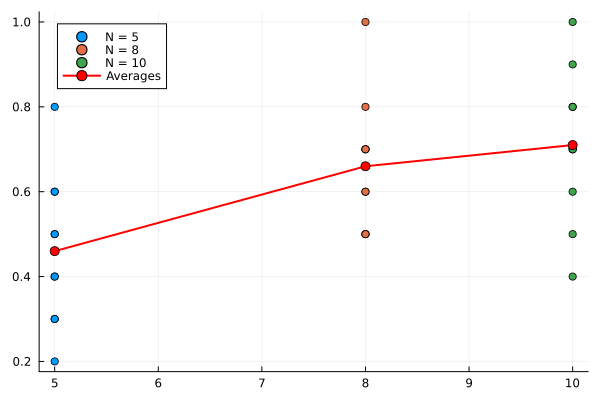

In [55]:
if true

    p = scatter()
    
    for (i, vec) in enumerate(p0_mat)
        x_values = repeat([N_list[i]], length(vec))  # X-axis value for each dot is the index in N_list
        scatter!(x_values, vec, label = "N = $(N_list[i])")  # Add scatter points for each vector
    end

    # Calculate the averages of each vector in p0_mat
    averages = [mean(vec) for vec in p0_mat]
    
    # Plot a line linking the averages
    plot!(N_list, averages, label = "Averages", lw=2, color=:red, marker=:circle, markersize=5)

    display(p)
    
end

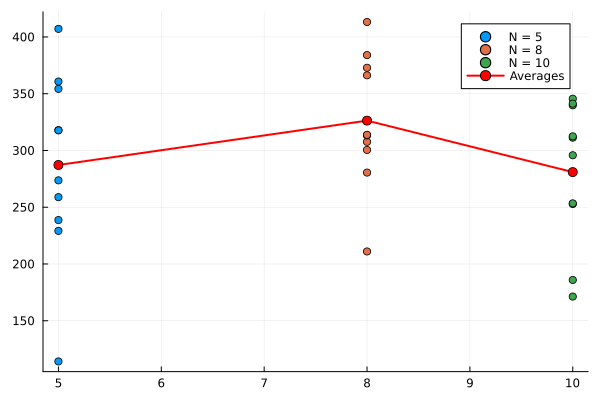

In [56]:
if true

    p = scatter()
    
    for (i, vec) in enumerate(t0_mat)
        x_values = repeat([N_list[i]], length(vec))  # X-axis value for each dot is the index in N_list
        scatter!(x_values, vec, label = "N = $(N_list[i])")  # Add scatter points for each vector
    end

    # Calculate the averages of each vector in p0_mat
    averages = [mean(vec) for vec in t0_mat]
    
    # Plot a line linking the averages
    plot!(N_list, averages, label = "Averages", lw=2, color=:red, marker=:circle, markersize=5)

    display(p)
    
end